# Test du code Pytorch

In [1]:
import sys
sys.path.append('../src')
import shutil
import yaml
import py7zr
import os
import s3fs
from satellite_image import SatelliteImage
from labeler import RILLabeler
from labeler import BDTOPOLabeler
from labeled_satellite_image import SegmentationLabeledSatelliteImage
from utils import *
from filter import *
import matplotlib.pyplot as plt
import numpy as np
import rasterio.plot as rp
import re
from datetime import datetime
from tqdm import tqdm

In [2]:
update_storage_access()

## Téléchargement des données Pléiades

In [3]:
environment = get_environment()

bucket = environment["bucket"]
path_s3_pleiades_data = environment["sources"]["PLEIADES"]
path_s3_bdtopo_data = environment["sources"]["BDTOPO"][2022]["guyane"]
path_local_pleiades_data = environment["local-path"]["PLEIADES"]
path_local_bdtopo_data = environment["local-path"]["BDTOPO"][2022]["guyane"]

fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})

On télécharge les fichiers depuis s3 (à mettre dans le setup.sh?)

In [ ]:
fs.download(
        rpath=f"{bucket}/{path_s3_pleiades_data}",
        lpath=f"../{path_local_pleiades_data}",
        recursive=True)

In [ ]:
fs.download(
        rpath=f"{bucket}/{path_s3_bdtopo_data}",
        lpath=f"../{path_local_bdtopo_data}",
        recursive=True)

## Découpage et filtrage des images

In [4]:
images_paths = [f"../{path_local_pleiades_data}/16bits/ORT_2022072050325085_U22N/" + p for p in os.listdir(f"../{path_local_pleiades_data}/16bits/ORT_2022072050325085_U22N/")]

In [5]:
date = datetime.strptime(re.search(r'ORT_(\d{8})', images_paths[0]).group(1), '%Y%m%d')

On importes les `SatelliteImage` dans une liste.

In [6]:
list_images = [
     SatelliteImage.from_raster(
        filename,
        dep = "973",
        date = date, 
        n_bands = 4
    ) for filename in tqdm(images_paths)]

100%|██████████| 240/240 [01:17<00:00,  3.09it/s]


On découpe les images initialement de dimension 2000 en plusieurs image de dimension `dim`. On ne garde ensuite que les images qui sont pertinentes à l'aide de la méthode `filter_images`. Une image contenant moins de 50% de pixels non noirs n'est pas retenue.

In [7]:
dim = 250

In [8]:
splitted_list_images = [im for sublist in tqdm(list_images) for im in sublist.split(250) if not is_too_black(im)]

100%|██████████| 240/240 [00:09<00:00, 26.62it/s]


In [9]:
len(splitted_list_images)

13254

On peut représenter graphiquement nos images grâce à la méthode `plot` :

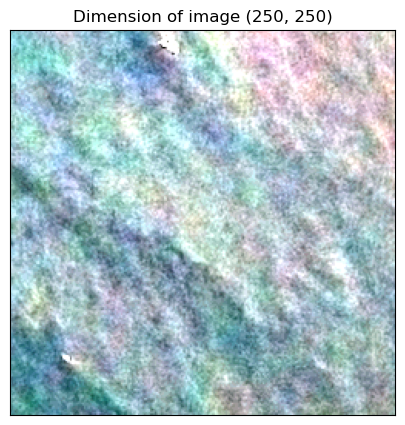

In [10]:
splitted_list_images[2793].plot([0, 1, 2]) # RGB (3 premières bandes)

On peut représenter l'image infrarouge : 

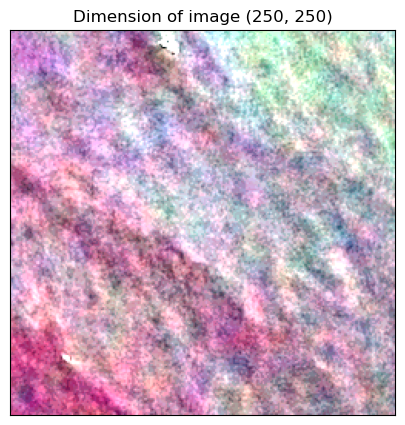

In [11]:
splitted_list_images[2793].plot([3, 0, 1]) # RGB (Infrarouge, rouge, vert)

Ou bien qu'une seule bande :

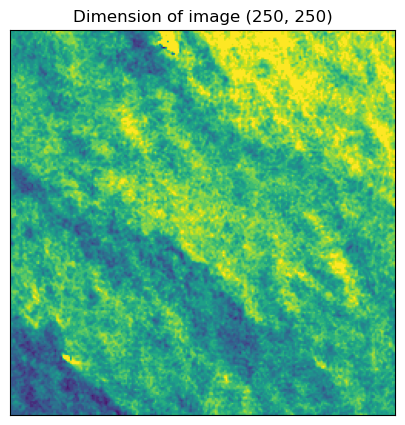

In [12]:
splitted_list_images[2793].plot([0]) # Une bande

## Labélisation avec le RIL

On définit un `labeler` incluant la taille des buffers que l'on souhaite ainsi que la forme de ceux-ci.

In [109]:
labeler_RIL = RILLabeler(date, dep="973", buffer_size=6, cap_style=3)

A l'aide de notre `labeler` on créer une `SegmentationLabeledSatelliteImage`.

In [110]:
list_labeled_images = []
for sat_im in tqdm(splitted_list_images[:30]):
    sat_im.normalize()
    list_labeled_images.append(
        SegmentationLabeledSatelliteImage(
            sat_im,
            labeler_RIL.create_segmentation_label(sat_im),
            "RIL",
            date
        )
    )

 13%|█▎        | 4/30 [00:00<00:00, 29.75it/s]

 40%|████      | 12/30 [00:00<00:00, 34.26it/s]

 70%|███████   | 21/30 [00:00<00:00, 32.52it/s]

100%|██████████| 30/30 [00:00<00:00, 33.98it/s]

In [111]:
splitted_list_images[0].to_tensor().shape

torch.Size([4, 250, 250])

In [112]:
splitted_list_images[0].to_tensor([0, 1, 2]).shape

torch.Size([3, 250, 250])

### Dataset

In [113]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
from dataset import SatelliteDataset

In [115]:
from dataset import SatelliteDataModule

data_module = SatelliteDataModule(
    train_data=list_labeled_images[:20],
    test_data=list_labeled_images[20:],
    num_workers=0
)

In [116]:
train_dataloader = data_module.train_dataloader()

In [117]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([8, 4, 250, 250])
Labels batch shape: torch.Size([8, 250, 250])


In [118]:
img = train_features[0].squeeze()

In [119]:
img.shape

torch.Size([4, 250, 250])

In [120]:
img[[0, 1, 2], :, :].shape

torch.Size([3, 250, 250])

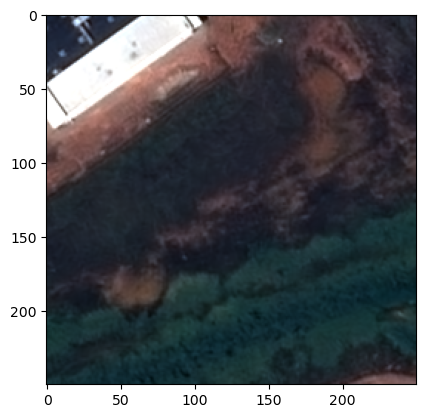

In [123]:
plt.imshow(np.transpose(img[[0, 1, 2], :, :], (1, 2, 0)))
plt.show()

In [124]:
label = train_labels[0]
label.shape

torch.Size([250, 250])

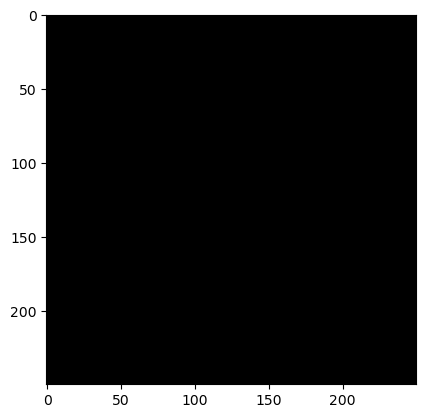

In [125]:
plt.imshow(label, cmap="gray")
plt.show()

In [126]:
for label in train_labels:
    print(label.sum())

tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(625., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)


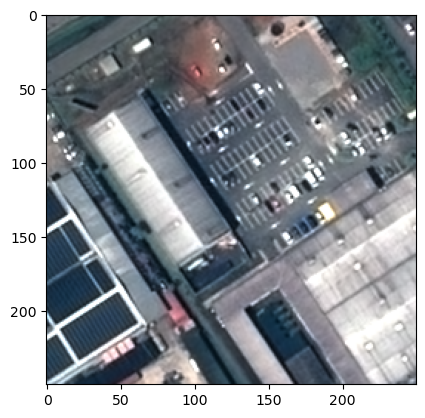

In [127]:
img = train_features[2].squeeze()

plt.imshow(np.transpose(img[[0, 1, 2], :, :], (1, 2, 0)))
plt.show()

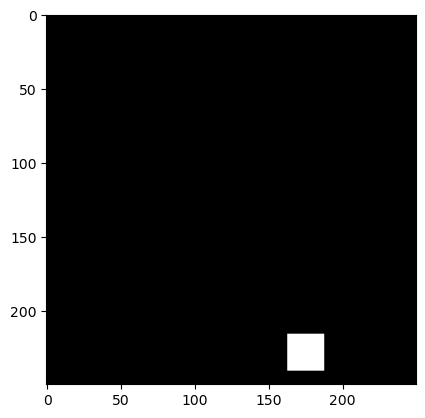

In [128]:
label = train_labels[2]
plt.imshow(label, cmap="gray")
plt.show()

### Test avec BDTOPO

In [129]:
labeler_BDTOPO = BDTOPOLabeler(date, dep="973")

In [130]:
list_labeled_images = [
   SegmentationLabeledSatelliteImage(
      sat_im,
      labeler_BDTOPO.create_segmentation_label(sat_im),
      "BDTOPO",
      date
   ) for sat_im in tqdm(splitted_list_images[:30])]

100%|██████████| 30/30 [00:01<00:00, 19.00it/s]


In [131]:
data_module = SatelliteDataModule(
    train_data=list_labeled_images[:20],
    test_data=list_labeled_images[20:],
    num_workers=0
)

In [132]:
train_dataloader = data_module.train_dataloader()

In [133]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([8, 4, 250, 250])
Labels batch shape: torch.Size([8, 250, 250])


In [134]:
img = train_features[0].squeeze()

In [135]:
img.shape

torch.Size([4, 250, 250])

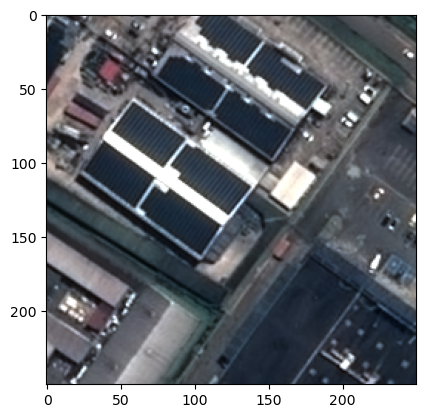

In [145]:
plt.imshow(np.transpose(img[[0, 1, 2], :, :], (1, 2, 0)))
plt.show()

In [137]:
label = train_labels[0]
label.shape

torch.Size([250, 250])

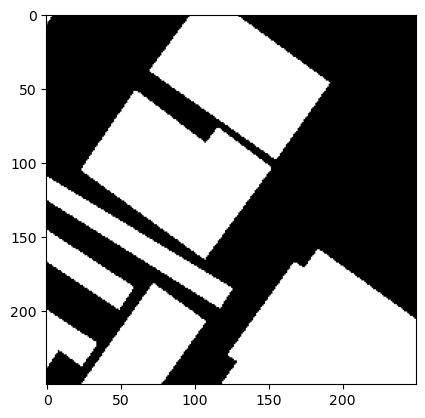

In [138]:
plt.imshow(label, cmap="gray")
plt.show()

### Add transforms

In [139]:
import albumentations as album
from albumentations.pytorch.transforms import ToTensorV2

In [140]:
image_size = (250, 250)
# Some additional normalization is done here
transforms_augmentation = album.Compose(
    [
        album.Resize(300, 300, always_apply=True),
        album.RandomResizedCrop(
            *image_size, scale=(0.7, 1.0), ratio=(0.7, 1)
        ),
        album.HorizontalFlip(),
        album.VerticalFlip(),
        album.Normalize(),
        ToTensorV2(),
    ]
)

In [141]:
transforms_preprocessing = album.Compose(
    [
        album.Resize(*image_size, always_apply=True),
        album.Normalize(),
        ToTensorV2(),
    ]
)

In [142]:
data_module = SatelliteDataModule(
    train_data=list_labeled_images[:20],
    test_data=list_labeled_images[20:],
    transforms_augmentation=transforms_augmentation,
    transforms_preprocessing=transforms_preprocessing,
    num_workers=0,
    bands_indices=[0, 1, 2]
)

train_dataloader = data_module.train_dataloader()
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([8, 3, 250, 250])
Labels batch shape: torch.Size([8, 250, 250])


In [143]:
test_dataloader = data_module.test_dataloader()
test_features, test_labels = next(iter(test_dataloader))

In [144]:
train_dataloader

## Model training

In [150]:
import torch
import torchvision
from torch import nn

In [152]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = "cpu"

print("Using {} device".format(device))
if torch.cuda.is_available():
    print("Nom du GPU : ", torch.cuda.get_device_name(device=None))
    print("GPU initialisé : ", torch.cuda.is_initialized())

# Load the pretrained model
model = torchvision.models.segmentation.deeplabv3_resnet101(
    weights='DeepLabV3_ResNet101_Weights.DEFAULT'
)
# 1 classe !
model.classifier[4] = nn.Conv2d(
    256,
    2,
    kernel_size=(1, 1),
    stride=(1, 1))
model = model.to(device)

Using cpu device


In [155]:
model.classifier[4]

Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))

In [156]:
# Initialize the number of parameters
total_params = 0

# Loop through the parameters in the model
for param in model.parameters():
    # Get the size of the parameter tensor
    size = param.size()
    # Multiply the size of the tensor by the number of elements in it
    num_params = torch.prod(torch.tensor(size)).item()
    # Add the number of parameters to the total
    total_params += num_params

# Print the total number of parameters
print("Total number of parameters: ", total_params)

Total number of parameters:  60991319


In [159]:
# Perte
loss_fn = torch.nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

# Train the model
for epoch in range(2):
    running_loss = 0.0
    t = tqdm(
        train_dataloader,
        desc="epoch %i" % (epoch+1),
        position = 0,
        leave=True
    )
    epoch_loop = enumerate(t)

    for i, data in epoch_loop:
        images = data[0].to(device)
        labels = data[1].type(torch.LongTensor).to(device)
        optimizer.zero_grad()
        output = model(images)["out"]
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

        del images, labels, output
        running_loss += loss.item()

epoch 2: 100%|██████████| 2/2 [00:16<00:00,  8.19s/it]


Avec PL

In [169]:
from deeplabv3 import DeepLabv3Module
from torch import optim
from pytorch_lightning.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    LearningRateMonitor,
)
import pytorch_lightning as pl

optimizer = torch.optim.SGD
optimizer_params = {
    "lr": 0.0001,
    "momentum": 0.9
}
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau
scheduler_params = {}
scheduler_interval = "epoch"

model = DeepLabv3Module(
        optimizer=optimizer,
        optimizer_params=optimizer_params,
        scheduler=scheduler,
        scheduler_params=scheduler_params,
        scheduler_interval=scheduler_interval
    )

checkpoint_callback = ModelCheckpoint(
    monitor="validation_loss", save_top_k=1, save_last=True, mode="min"
)
early_stop_callback = EarlyStopping(
    monitor="validation_loss", mode="min", patience=3
)
lr_monitor = LearningRateMonitor(logging_interval="step")

trainer = pl.Trainer(
    callbacks=[lr_monitor, checkpoint_callback, early_stop_callback],
    max_epochs=2,
    gpus=0,
    num_sanity_val_steps=2,
    strategy=None
)
trainer.fit(model, datamodule=data_module)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params
-------------------------------------------
0 | model | DeepLabV3        | 61.0 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
61.0 M    Trainable params
0         Non-trainable params
61.0 M    Total params
243.965   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


In [170]:
trainer.test(datamodule=data_module)

/opt/mamba/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:124: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at /home/onyxia/work/detection-bidonvilles/notebooks/lightning_logs/version_4/checkpoints/epoch=1-step=4.ckpt
Loaded model weights from checkpoint at /home/onyxia/work/detection-bidonvilles/notebooks/lightning_logs/version_4/checkpoints/epoch=1-step=4.ckpt
/opt/mamba/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 56 which is the

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7738022804260254
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.7738022804260254}]